In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision

from PIL import Image
import os

In [3]:
# path
input_path = "/home/piai/ResNet/resnet_data/pilseo_new/"

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + 'validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

In [5]:
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
print(labels)

tensor([ 55, 198, 546, 770, 463, 510,  38, 522,  96, 698, 510, 144, 388, 768,
        147, 770, 551, 401,  62, 656, 414, 805, 271, 731, 659,  44, 345,  36,
        477, 650, 794, 510])


In [6]:
classes = image_datasets['train'].classes

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## weight 파일 변경

In [8]:
model = models.resnet101(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 831)).to(device)
model.load_state_dict(torch.load('/media/piai/E572-EA40/psh/weights/weights_42.h5'))

<All keys matched successfully>

## test 이미지 20개 랜덤추출

In [9]:
import random

path = "/home/piai/ResNet/resnet_data/pilseo_new/test/"
file_list = os.listdir(path)

validation_img_paths = random.sample(file_list, 20)
val_img = []
for img_folder in validation_img_paths:
    val_img.append(path+img_folder+'/'+random.sample(os.listdir(path+img_folder), 1)[0])

In [10]:
img_list = [Image.open(input_path).convert('RGB') for input_path in val_img]

In [11]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [12]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

/home/piai/anaconda3/envs/posco14/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[-61.9620, -30.2349, -56.8120,  ..., -50.3472, -68.2132, -42.8158],
        [-36.1005, -39.3726, -33.1384,  ..., -28.4611, -29.2258, -36.8299],
        [-36.8985, -43.7955, -47.7935,  ..., -51.9267, -43.7082, -54.6551],
        ...,
        [-17.4502, -46.9138, -21.9110,  ..., -58.1010, -15.3001, -53.1690],
        [-36.5722, -52.6159, -32.5408,  ..., -85.2876, -49.6390, -55.4987],
        [-32.9445, -25.5947, -37.3297,  ...,  -8.9895, -29.5934, -22.4663]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [13]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[4.8241116e-19, 2.8995972e-05, 8.3179191e-17, ..., 5.3412441e-14,
        9.3012229e-22, 9.9651926e-11],
       [4.4966264e-10, 1.7055090e-11, 8.6962588e-09, ..., 9.3461375e-07,
        4.3506205e-07, 2.1683798e-10],
       [4.4659314e-06, 4.5143809e-09, 8.2845418e-11, ..., 1.3281440e-12,
        4.9258593e-09, 8.6760202e-14],
       ...,
       [5.1858830e-03, 8.2971943e-16, 5.9914466e-05, ..., 1.1492492e-20,
        4.4522766e-02, 1.5935200e-18],
       [2.4199728e-06, 2.6068316e-13, 1.3634982e-04, ..., 1.6864656e-27,
        5.1163479e-12, 1.4592845e-14],
       [1.3716855e-14, 2.1343486e-11, 1.7092682e-16, ..., 3.4736702e-04,
        3.9140230e-13, 4.8740895e-10]], dtype=float32)

## 폴더와 라벨링 매칭 파일

In [14]:
label_df = pd.read_csv('/home/piai/ResNet/resnet_data/필사본_new2.csv')

In [15]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트
font_name = fm.FontProperties(fname="/usr/share/fonts/nanum/NanumGothicExtraBold.ttf").get_name()
plt.rc('font', family=font_name)

In [16]:
def max_prob(class_all, idx):
    _max = -99
    max_p = []
    for j in range(len(class_all)):
        if _max < pred_probs[idx,j]:
            _max = pred_probs[idx,j]
            max_p.append((pred_probs[idx,j], j))
            
    return max_p

In [19]:
max_list[-2][1]

14

/home/piai/anaconda3/envs/posco14/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 4510 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/envs/posco14/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 4513 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/envs/posco14/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 4397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/envs/posco14/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 4399 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/envs/posco14/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 4510 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/piai/anaconda3/envs/posco14/lib

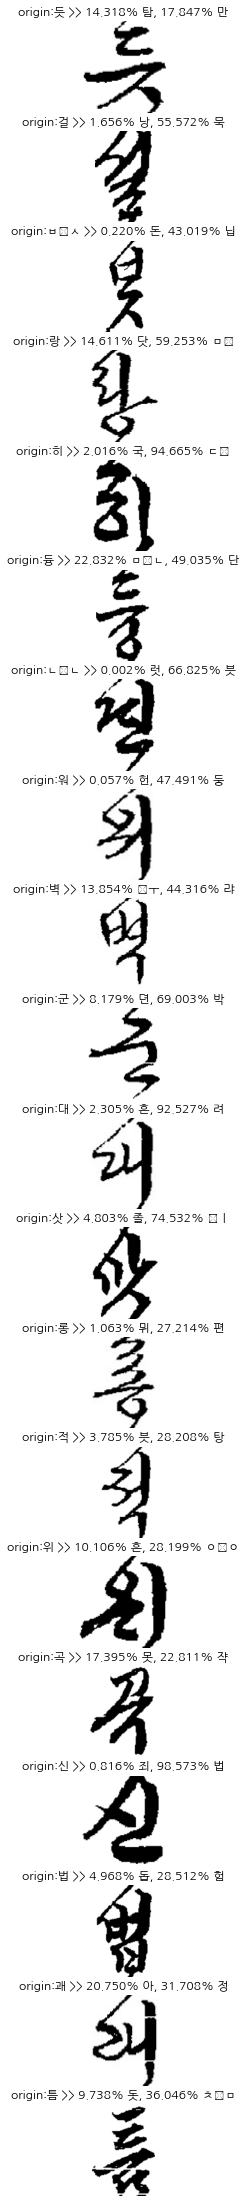

In [17]:
fig, axs = plt.subplots(len(img_list), 1, figsize=(15, 40))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    max_list = max_prob(classes, i)
    
    ori_lb = label_df.at[int(validation_img_paths[i]), 'label']
    lb1 = label_df.at[max_list[-2][1], 'label']
    lb2 = label_df.at[max_list[-1][1], 'label']
    
    if ori_lb == lb1 or ori_lb == lb2:
        print("correct!!!!!!!!!!!!!!!!!!!!!!!!!!! %d"%i)
        
    #print(lb1, lb2)
    ax.set_title("origin:{} >> {:.3f}% {}, {:.3f}% {}".format(ori_lb, 100*max_list[-2][0],lb1,
                                                            100*max_list[-1][0], lb2))
    ax.imshow(img)
    
plt.show()